# Using Azure ML Pipelines to Productionize E2E ML Workflows: Part I

**Learning Objectives** 
By the end of this tutorial, you should be able to use Azure Machine Learning (AML) to productionize your ML project. This means you will be able to:

    - Connet to your AML worskpace from the Python SDK
    - Create AML Datasets
    - Create AML Components from our Python code
    - Create, validate and run AML pipelines  
    - Deploy the newly-trained model as an enpoint
    - Call the AML endpoint for inferencing
    
After part II, you should be able to:

    - Load pre-registered Components
    - Use multi-note clusters for data processing and model training
    - Use AML for Hyper Parameter Optimization


**Motivations** 
This tutorial is intended to introduce AML to data scientists who want to scale up or publish their ML projects. By completing a familiar end-to-end project, which starts by loading the data and ends by creating and calling an online inference endpoint, the user should become familiar with the core concepts of AML and their most common usage. Each step of this tutorial can be modified or performed in other ways that might have security or scalability advantages. We will cover some of those in the Part II of this tutorial, however, we suggest the reader use the provide links in each section to learn more on each topic.

**Requirements**
In order to benefit from this tutorial, you need to have:
- basic understanding of Machine Learning projects workflow
- an Azure subscription. If you don't have an Azure subscription, [create a free account](https://aka.ms/AMLFree) before you begin.
- a working AML workspace. A workspace can be created via Azure Portal, Azure CLI, or Python SDK. [Read more](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace?tabs=python).
- a Python environmnet
- installed Azure Machine Learning Python SDK v2
```python
pip install azure-ml==0.0.139 --extra-index-url  https://azuremlsdktestpypi.azureedge.net/sdk-cli-v2
```


# 1. Introduction

In this tutorial, we will create an AML pipeline to train a model for credit default prediction. The pipeline handles the data preparation, training and registering the trained model. Image below depicts the visual representation of the pipeline. 
<div>
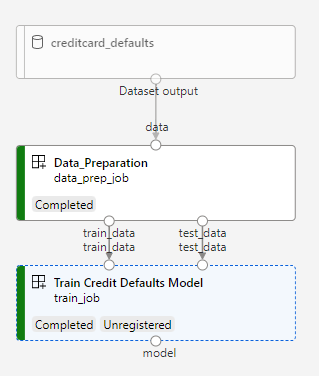
</div>


Once the training is finished, we publish the model as an endpoint and evaluate the inferencing endpoint, by invoking it with sample queries. 


# 2. Set Up the Pipeline Resources
Azure ML Framework can be used from CLI, Python SDK, or GUI. In this example we will use the Python SDK as indicated in the prerequisites section. The SDK will give us access to all the required packages. 

In this tutorial, we try to postpone the imports of the required packages to the section using that package, so that the user better understand the role of each entity. If you decide to run the cells out of the presented order, make sure you have imported the packages.

## 2.1. Connect to the Workspace
The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. 
Here we use the workspace identifier parameters to connect to the workspace. We use the default *interactive authentication* for this tutorial. More advanced connection methods can be found here [sdkv1link](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.authentication?view=azure-ml-py).

In [ ]:
# handle to the workspace
from azure.ml import MLClient

# Authentication package
from azure.identity import InteractiveBrowserCredential

In the next cell, we enter the *Subscription ID*, *Resource Group* name and *Workspace* name. The result is a handler to the workspace that we can use to manage other resources and jobs.

In [ ]:
# get a handle to the workspace
ml_client = MLClient(
    InteractiveBrowserCredential(), 
    subscription_id = '<SUBSCRIPTION_ID>', 
    resource_group = '<RESOURCE_GROUP>', 
    workspace = '<AML_WORKSPACE_NAME>'
)

## 2.2. Prepare Data
The data we use for out training, is normally in one of the locations below:
- Local Machine
- Web
- Big Data Storage services (e.g. Azure Blob, Azure Data Lake Storage, SQL... )

AML uses a Dataset object to consume data. A Dataset object is a pointer to a data storage service and a path. In the section below, we consume some data from web url as one example. Datasets from other sources can be created as well. 
For more information on various sources of data and their consumption, please check [sdkv1link](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-access-data). 

In [ ]:
from azure.ml.entities import Dataset

web_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

credit_dataset = Dataset(
    name="creditcard_defaults",
    paths=[dict(file=web_path)],
    description="Dataset for credit card defaults",
    tags={'source_type':'web',
          'source':'UCI ML Repo'
    },
)

This dataset object is ready to be consumed as a one-off object by the pipeline that we will define. We can also register the dataset to our workspace. This will enable us to:
- reuse and share the dataset in future pipelines
- use versions to track the modification to the dataset
- use the dataset from AML designer which is AML's GUI for pipeline authoring

Since this is the first time in this tutorial that we are making a call to the workspace, running the next cell should direct you to AML's web authentication page. Please login with your Azure credentials. Once you are logged in, you should receive a message that informs you that the authentication is complete and you can close the authentication window. You should then see the dataset registration completion below.

In [ ]:
credit_dataset = ml_client.create_or_update(credit_dataset)
print(f"Dataset with name \"{credit_dataset.name}\" was registered to workspace, the dataset version is {credit_dataset.version}")

In future, one can fetch the same dataset from the workspace using 
```python
credit_dataset = ml_client.datasets.get("<DATASET NAME>", version='<VERSION>')
```

## 2.3. Create a Compute Resource

Each step of an AML pipelines can use a different compute resource for running the specific job of that step. It can be single or multi-node machines with Linux or Windows OS, or a specific compute fabric like spark. 

In this section, we provision a Linux compute cluster for our tasks in this tutorial. Let's start by listing the available VM sizes available for use. You can check [here](https://azure.microsoft.com/en-ca/pricing/details/machine-learning/) for a full list on VM sizes and prices.

In [ ]:
from azure.ml.entities import AmlCompute, Compute
import pandas as pd
# Let's have a peak at the most important properties
VM_dict = {
    vm.name: {
        "family": vm.family,
        "hdd_size": vm.os_vhd_size_mb,
        "memory": vm.memory_gb,
        "cpus": vm.v_cp_us,
        "gpus": vm.gpus,
    }
    for vm in ml_client.compute.list_sizes()
}
VM_df = pd.DataFrame.from_dict(VM_dict, orient='index')

# Let's take a look at one VM Family, you can change the code and explore more
VM_df[VM_df['family']=='standardDSv2Family']

For this tutorial we only need a basic cluster, let's pick *Standard_DS2_v2* and create am AML Compute

In [ ]:
# Let's create the AML compute object with the intended parameters
cluster_basic = AmlCompute(
    # Name assigned to the compute cluster
    name="cpu-cluster",
    
    # AML Compte is AML's on-demand VM service
    type="amlcompute",
   
    # VM Family
    size="Standard_DS2_v2",
    
    # Minimum running nodes when there is no job running
    min_instances=0,
    
    # nodes in cluster
    max_instances=2,
    
    # How many seconds will the node running after the job termination
    idle_time_before_scale_down=120,
    
    # dedicated or LowPriority. The latter is cheaper but there is a chance of job termination 
    tier='dedicated'
)

# Now, we pass the object to clinet's create_or_update method
ml_client.begin_create_or_update(cluster_basic)

## 2.4. Create a Job Environment
So far, in the requirements section, we have created a development environment on our development machine. AML needs to know what environment to use for each step of the pipeline. We can use any published docker image as is, or add or required dependencies to the image.In this example, we create a conda environment for our jobs, using a [conda yaml file](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#create-env-file-manually) and add it to an Ubuntu image in Microsoft Container Registry. For more information on AML environments and Azure Container Registries, please check [sdkv1link](https://docs.microsoft.com/en-us/azure/machine-learning/concept-environments).


In [ ]:
import os
dependencies_dir = "./dependencies"
os.makedirs(dependencies_dir, exist_ok=True)

In [ ]:
%%writefile {dependencies_dir}/conda.yml
name: model-env
channels:
  - conda-forge
dependencies:
  - python=3.7
  - numpy=1.21.2
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pandas>=1.1,<1.2
  - pip:
    - azureml-defaults==1.38.0
    - azureml-mlflow==1.38.0
    - inference-schema[numpy-support]==1.3.0
    - joblib==1.0.1
    - xlrd==2.0.1

Here we added some common packages we use in our pipelie:

    - numpy=1.21.2
    - pip=21.2.4
    - scikit-learn=0.24.2
    - scipy=1.7.1
    - pandas>=1.1,<1.2
    - joblib
    - xlrd
together with some AML specific packages:

    - azureml-defaults==1.38.0
    - azureml-mlflow==1.38.0
    
these AML packages are not mandatory to run AML jobs, however, adding those will let us interact with AML for logging metrics and registering models, all inside the AML job.

In [ ]:
from azure.ml.entities import Environment
custom_env_name = 'aml-scikit-learn'

pipeline_job_env = Environment(
    name = custom_env_name,
    description = 'Custom environment for Credit Card Defaults pipeline',
    tags = {'scikit-learn':'0.24.2',
           'azureml-defaults':'1.38.0'},
    conda_file=os.path.join(dependencies_dir, "conda.yml"),
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210727.v1",
)
pipeline_job_env = ml_client.environments.create_or_update(pipeline_job_env)

# 3. Create the Training Pipeline
AML pipelines are reusable ML workflows that usually consist of several components. AML defines these components in yaml files. One can directly write the yaml file or use the ComponentMethod to create a component. 


## 3.1. Create or Load Components
Now that we have our workspace, compute and input data ready, let's work on the individual steps of our pipeline. 

### 3.1.1 Data Preparation Component

Let's start by creating the first component. This component handles the preprocessing of the data. The preprocessing task is performed in the *data_prep.py* python file.

Let's first create a source folder for the data_prep component:


In [ ]:
import os
data_prep_src_dir = "./components/data_prep"
os.makedirs(data_prep_src_dir, exist_ok=True)

This script performs the simple task of splitting the data into train and test datasets. 
AML mounts datasets as folders to the computes, therefore, we created an auxiliary `select_first_file` function to access the data file inside the mounted input folder.
mlflow can be used to log the parameters and metrics during our pipeline run. A detailed guide on AML logging is available [here](https://github.com/Azure/azureml-examples/blob/sdk-preview/notebooks/mlflow/mlflow-v1-comparison.ipynb). 


In [ ]:
%%writefile {data_prep_src_dir}/data_prep.py
import os
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
from azureml.core import Run
import mlflow


def select_first_file(path):
    """Selects first file in folder, use under assumption there is only one file in folder
    Args:
        path (str): path to directory or file to choose
    Returns:
        str: full path of selected file
    """
    files = os.listdir(path)
    return os.path.join(path, files[0])


# input and output arguments
parser = argparse.ArgumentParser()
parser.add_argument("--data")
parser.add_argument("--split_ratio", type=float, required=False, default=0.25)
parser.add_argument("--train_data")
parser.add_argument("--test_data")
args = parser.parse_args()

# Start Logging
mlflow.start_run()

print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

print("input data:", select_first_file(args.data))

credit_df = pd.read_excel(select_first_file(args.data), header=1, index_col=0)

mlflow.log_metric("num_samples", credit_df.shape[0])
mlflow.log_metric("num_features", credit_df.shape[1] - 1)

credit_train_df, credit_test_df = train_test_split(
    credit_df,
    test_size=args.split_ratio,
)

# output paths are mounted as folder, therefore, we are adding a filename to the path
credit_train_df.to_csv(os.path.join(args.train_data, "data.csv"), index = False)

credit_test_df.to_csv(os.path.join(args.test_data, "data.csv"), index = False)

# Stop Logging
mlflow.end_run()

Now that we have a script that can perform the desired task, we can create an AML Component from it. AML support various types of components for performing ML tasks, such as running scripts, data transfer, etc. Here we use the general purpose CommandComponent that can run command line actions. This command line action can be directly calling system or running a script. The inputs/outputs are accessible in the command via the `${{parameter}}` notation.

A component can be created by calling the component instantiators, or directly writing the defining yaml file. For the first component, we use the `CommandComponent` class.

In [ ]:
# importing the CommandComponent Package
from azure.ml.entities import CommandComponent

# importing the CommandComponent Package
from azure.ml.entities import Code

data_prep_component = CommandComponent(
    # Name of the component
    name="Data_Preparation",
    
    # Component Version, no Version and the component will be automatically versioned 
#     version="26",
    
    # The dictionary of the inputs. Each item is a dictionary itself.
    inputs=dict(
        data=dict(type="path"),
        split_ratio=dict(type="integer"),
    ),
    
    # The dictionary of the outputs. Each item is a dictionary itself.
    outputs=dict(
        train_data=dict(type="path"),
        test_data=dict(type="path"),
    ),
    
    # The source folder of the component
    code=Code(local_path=data_prep_src_dir),
    
    # The environment the component job will be using
    environment=pipeline_job_env,
    
    # The command that will be run in the component
    command="python data_prep.py --data ${{inputs.data}} --split_ratio ${{inputs.split_ratio}} "
    "--train_data ${{outputs.train_data}} --test_data ${{outputs.test_data}} ",
)

data_prep_component = ml_client.create_or_update(data_prep_component)

### 3.1.2. Training Component

The second component that we will create will consume the training and test data, train a tree based model and then returns the output model. We use AML logging capabilities to record and visualize the learning progress.

Once the model is trained, the model file is saved and registered to the workspace. This will allow us to use the registered model in inferencing endpoints.



In [ ]:
import os
train_src_dir = "./components/train"
os.makedirs(train_src_dir, exist_ok=True)

In [ ]:
%%writefile {train_src_dir}/train.py
import argparse
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from azureml.core.model import Model
from azureml.core import Run
import os
import pandas as pd
import joblib
import mlflow


def select_first_file(path):
    """Selects first file in folder, use under assumption there is only one file in folder
    Args:
        path (str): path to directory or file to choose
    Returns:
        str: full path of selected file
    """
    files = os.listdir(path)
    return os.path.join(path, files[0])


# Start Logging
mlflow.start_run()

# enable autologging
mlflow.sklearn.autolog()

# This line creates a handles to the current run. It is used for model registration
run = Run.get_context()

os.makedirs("./outputs", exist_ok=True)

# input and output arguments
parser = argparse.ArgumentParser()
parser.add_argument("--train_data")
parser.add_argument("--test_data")
parser.add_argument("--registered_model_name")
parser.add_argument("--model")
args = parser.parse_args()

# paths are mounted as folder, therefore, we are selecting the file from folder
train_df = pd.read_csv(select_first_file(args.train_data))

# Extracting the label column
y_train = train_df.pop("default payment next month")

# convert the dataframe values to array
X_train = train_df.values

# paths are mounted as folder, therefore, we are selecting the file from folder
test_df = pd.read_csv(select_first_file(args.test_data))

# Extracting the label column
y_test = test_df.pop("default payment next month")

# convert the dataframe values to array
X_test = test_df.values

print(f'Training with data of shape {X_train.shape}')

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


# setting the full path of the model file
model_file = os.path.join(args.model, "model.pkl")
with open(model_file, "wb") as mf:
    joblib.dump(clf, mf)


# Registering the model to the workspace
model = Model.register(
    run.experiment.workspace,
    model_name=args.registered_model_name,
    model_path=model_file,
    tags={"type": "sklearn.GradientBoostingClassifier"},
    description = 'Model created in AML on credit card defaults dataset',
)


# Stop Logging
mlflow.end_run()

We observed how we create a component using `CommandComponnet` class. This time we use the yaml definition for defining our component. Each method has its own advantages. A yaml definition is more favored for code revision and history tracking, and the class method can be easier with built-in class documentation and code completion.

For the environment, we can use one of the built-in AML environments. The tag `azureml`, tells the system to use look for the name in the previously built environments. 

In [ ]:
%%writefile {train_src_dir}/train.yml
# <component>
name: TrainCreditDefaultsModel
display_name: Train Credit Defaults Model
version: 1
type: command
inputs:
    train_data: 
        type: path
    test_data: 
        type: path
    registered_model_name:
        type: string
outputs:
    model:
        type: path
code:
    local_path: .
environment:
    azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu:21
command: >-
    python train.py 
    --train_data ${{inputs.train_data}} 
    --test_data ${{inputs.test_data}} 
    --registered_model_name ${{inputs.registered_model_name}} 
    --model ${{outputs.model}}
# </component>


In [ ]:
# # This will be removed after confirmation
# # importing the CommandComponent Package
# from azure.ml.entities import CommandComponent

# # importing the CommandComponent Package
# from azure.ml.entities import Code


# environment = "AzureML-sklearn-0.24-ubuntu18.04-py37-cpu:5"

# train_component = CommandComponent(
#     name="Train",
#     version="23",
#     inputs=dict(
#         train_data=dict(type="path"),
#         test_data=dict(type="path"),
#         registered_model_name = {'type':'string'}
#     ),
#     outputs=dict(
#         model=dict(type="path"),
#     ),
#     code=Code(local_path=train_src_dir),
#     environment=env,
#     command="python train.py --train_data ${{inputs.train_data}} --test_data ${{inputs.test_data}} "
#     "--registered_model_name ${{inputs.registered_model_name}} --model ${{outputs.model}} ",
# )

# ml_client.create_or_update(train_component)

## 3.2. Creating the Pipeline from Components
Now that both our components are defined, we can start creating the pipeline. First, we load the component, this way, we can use them in our pipeline like functions.


In [ ]:
from azure.ml import dsl, MLClient
from azure.ml.dsl import Pipeline
from azure.ml.entities import Component as ComponentEntity, Dataset
from pathlib import Path


# Let's load the data-perp component from the workspace
data_prep_func = dsl.load_component(
    client=ml_client,
    name=data_prep_component.name,
    version=data_prep_component.version,
)

# Let's load the train func from the local yaml file
train_func = dsl.load_component(
    yaml_file=os.path.join(train_src_dir,'train.yml')
)


Then we use these operators in a pipeline. We use a specific `@dsl` decorator that identifies the AML pipelines. In the decorator, we can specify the pipeline description and default resources like compute and storage.

Pipeline can have inputs the we can use for different instantiations of the pipeline. Here, we used *input data*, *split ratio* and *registered model name* as variables. We then call teh components and connect them via their inputs/outputs. The outputs of each step can be accessed via the `.outputs` property.

In [ ]:
# the dsl decorator tells the sdk that we are defining an AML pipeline
@dsl.pipeline(
    compute="cpu-cluster",
    description="E2E data_perp-train pipeline",
)
def credit_defaults_pipeline(
    pipeline_job_data_input,
    pipeline_job_split_ratio,
    pipeline_job_registered_model_name,
):
    data_prep_job = data_prep_func(
        data=pipeline_job_data_input,
        split_ratio=pipeline_job_split_ratio,
    )
    train_job = train_func(
        train_data=data_prep_job.outputs.train_data,
        test_data=data_prep_job.outputs.test_data,
        registered_model_name=pipeline_job_registered_model_name,
    )

    return {
        "pipeline_job_train_data": data_prep_job.outputs.train_data,
        "pipeline_job_test_data": data_prep_job.outputs.test_data,
    }

Let's now use our pipeline definition to instantiate a pipeline with our dataset, split rate of choice and the name we picked for our model.

In [ ]:
registered_model_name = "credit_defaults_model"

# Let's instantiate the pipeline with the parameters of our choice
pipeline = credit_defaults_pipeline(
    pipeline_job_data_input=credit_dataset,
    pipeline_job_split_ratio=0.2,
    pipeline_job_registered_model_name=registered_model_name,
)

## 3.3. Submitting a Job to AML Workspace
It is now time to submit the job for running in AML. This time we use `create_or_update`  on `ml_client.jobs`. Here we also pass an experiment name. An experiment is a container for all the iterations one does on a certain project. All the jobs submitted under the same experiment name would be listed next to each other in AML studio.

In [ ]:
# submit the pipeline job
returned_job = ml_client.jobs.create_or_update(
    pipeline,
    
    # Project's name
    experiment_name="e2e_registered_components",
    
    # If there is no dependency, pipeline run will continue even after the failure of one component
    continue_run_on_step_failure=True,
)
# get a URL for the status of the job
returned_job.services["Studio"].endpoint

You can track the progress of your pipeline, by using the link generated in the cell above.
Clicking on each component, will reveal more information on that one. 
There are two important parts to look for at this stage:
- `Outputs+logs` > `user_logs` > `std_log.txt`
This section shows the script run sdtout
<div>
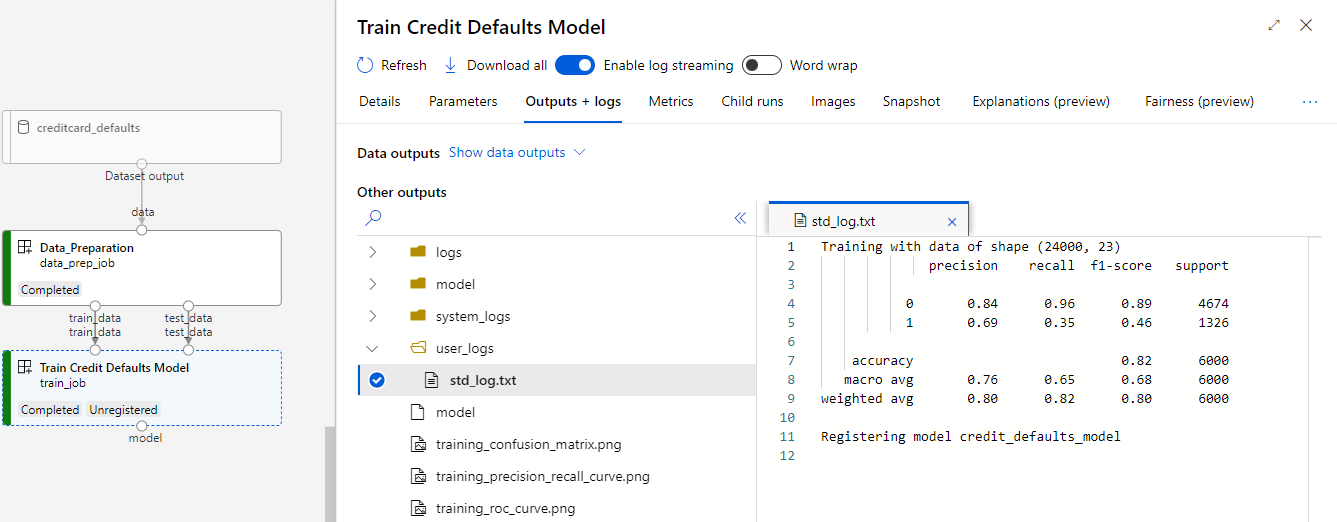
</div>

- `Outputs+logs` > `Metric`
This section shows different logged metrics. In this example. mlflow `autologging`, has automatically logged the training metrics.

<div>
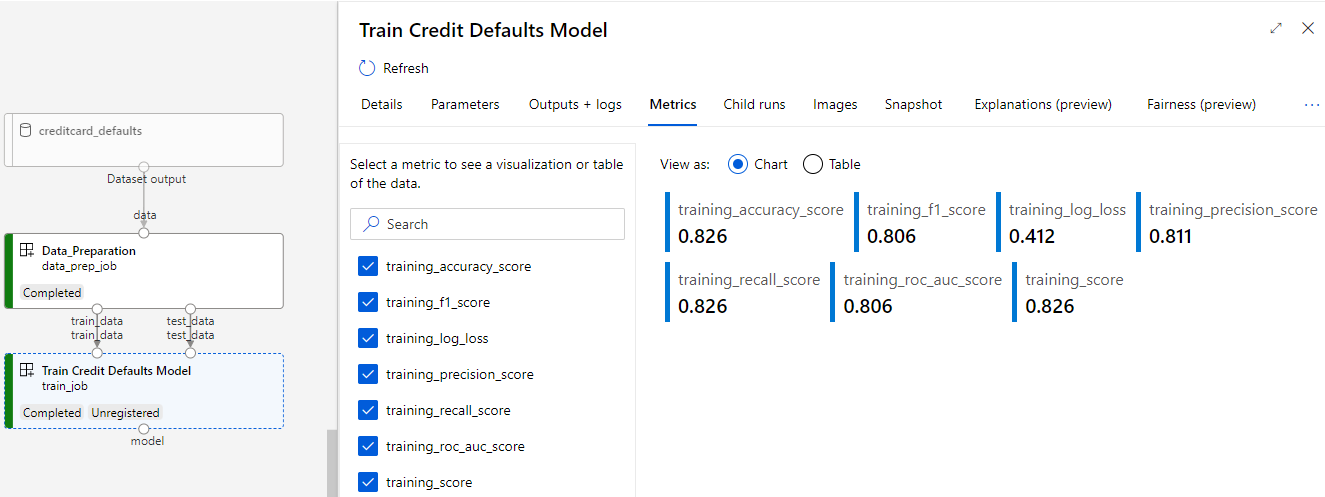
</div>

# 4. Deploy the Model as an Online Endpoint
Let's learn how to deploy your machine learning model as a web service in the Azure cloud [sdkv1link](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-and-where?tabs=azcli). 
A typical situation for a deployed machine learning service is that you need the following components:

 - Resources representing the specific model that you want deployed. We have done this step in our training component.
 - Code that you will be running in the service, that executes the model on a given input. This entry script receives data submitted to a deployed web service and passes it to the model. It then returns the model's response to the client. The script is specific to your model. The entry script must understand the data that the model expects and returns.

The two things you need to accomplish in your entry script are:

- Loading your model (using a function called init())
- Running your model on input data (using a function called run())

## 4.1. Creating an Inference Script
In the following implementation the `init()` function loads the model, and the run function expects the data in `json` format with the input data stored under `data`.

In [ ]:
deploy_dir = "./deploy"
os.makedirs(deploy_dir, exist_ok=True)

In [ ]:
%%writefile {deploy_dir}/score.py
import os
import logging
import json
import numpy
import joblib


def init():
    """
    This function is called when the container is initialized/started, typically after create/update of the deployment.
    You can write the logic here to perform init operations like caching the model in memory
    """
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    model_path = os.path.join(
        os.getenv("AZUREML_MODEL_DIR"), "model.pkl"
    )
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)
    logging.info("Init complete")


def run(raw_data):
    """
    This function is called for every invocation of the endpoint to perform the actual scoring/prediction.
    In the example we extract the data from the json input and call the scikit-learn model's predict()
    method and return the result back
    """
    logging.info("Request received")
    data = json.loads(raw_data)["data"]
    data = numpy.array(data)
    result = model.predict(data)
    logging.info("Request processed")
    return result.tolist()

## 4.2. Create a New Online Endpoint
It is now straight forward to create an online endpoint. First, we create an endpoint by providing its description. 

In [ ]:
from azure.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
)

#create an online endpoint
endpoint = ManagedOnlineEndpoint(name='credit-defaults-online-endpoint',
            description='this is an online endpoint',
            auth_mode='key',
            tags={'training_dataset': 'cradit_defaults',
                 'model_type':'sklearn.GradientBoostingClassifier'})
                     
ml_client.begin_create_or_update(endpoint)

## 4.3. Deploy the Model to the Endpoint
Then we deploy the model with the entry script as a deployment. Each endpoint can have multiple deployment and direct traffic to these deployment based on the provided rules. Here we create a single deployment that handles all the incoming traffic. 

In [ ]:
#create an online deployment. Use the latest version of your registered model
model = ml_client.models.get(name=registered_model_name, version=9)

blue_deployment = ManagedOnlineDeployment(
    name='blue',
    endpoint_name='credit-defaults-online-endpoint',
    model=model,
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu:21",
    code_local_path=deploy_dir,
    scoring_script="score.py",
    instance_type='Standard_DS2_v2',
    instance_count=1)

ml_client.begin_create_or_update(blue_deployment)

With the endpoint already published, we can run inference on any data. Let's create a sample request file following the design expected in the run method in the score script.

In [ ]:
%%writefile {deploy_dir}/sample-request.json
{"data": [
    [20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0], 
    [10,9,8,7,6,5,4,3,2,1, 10,9,8,7,6,5,4,3,2,1,10,9,8]
]}

In [ ]:
# test the blue deployment with some sample data
ml_client.online_endpoints.invoke(
    endpoint_name='credit-defaults-online-endpoint',
    request_file="./deploy/sample-request.json",
    deployment_name='blue'
)

It is possible to use consume the Rest endpoint directly [sdkv1link](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-and-where?tabs=python). 

# Next Steps
In part II of this tutorial, we will expand this work by using multi-node training and performing Hyper Parameter Optimization. 